# Corona_Virus visualization and China_trend prediction (Active Confirmed)

This kernel has a few goals:
1. To get trends visualization of Disease in TOP_countries
2. To make China_trend prediction for future 10 days

Any constructive feedback for improving are welcome!

# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import matplotlib.markers as mmark
import matplotlib.lines as mlines

from sklearn.impute import SimpleImputer

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import mean_absolute_error
plt.style.use('seaborn')


# Data Reading

In [2]:
data_main=pd.read_csv('../input/novel-corona-virus-2019-dataset/covid_19_data.csv')
#data_time_conf=pd.read_csv('time_series_covid_19_confirmed.csv')
#data_time_recov=pd.read_csv('time_series_covid_19_recovered.csv')
#data_time_deaths=pd.read_csv('time_series_covid_19_deaths.csv')

In [3]:
data_main.shape

(7926, 8)

In [4]:
#DateLine
print(data_main['ObservationDate'].min())
print(data_main['ObservationDate'].max())
#Countries
print('Uniq_countries',data_main['Country/Region'].nunique())
print('Uniq_prov (NAN_here)',data_main['Province/State'].nunique())

01/22/2020
03/22/2020
Uniq_countries 200
Uniq_prov (NAN_here) 282


In [5]:
#data_time_conf.shape

In [6]:
#data_time_deaths[:1]

# Main_file In-work

In [7]:
#Top 5 regions repeated in table
data_main['Country/Region'].value_counts()[:5]

Mainland China    1889
US                1617
Australia          323
Canada             254
France             127
Name: Country/Region, dtype: int64

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Recov_Rate,%')

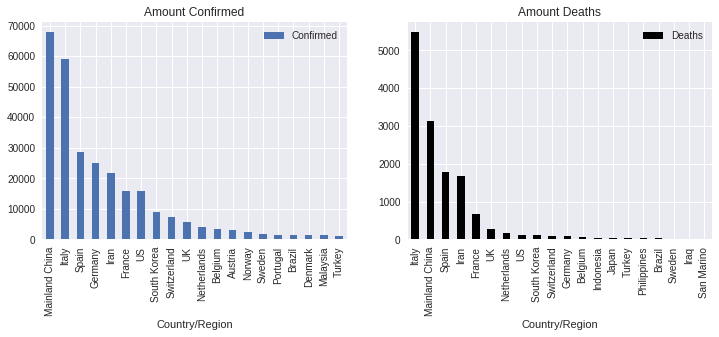

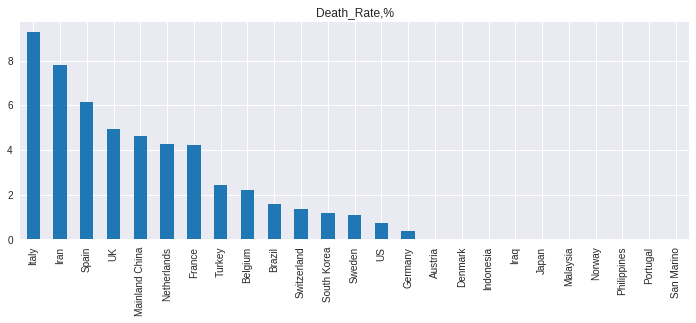

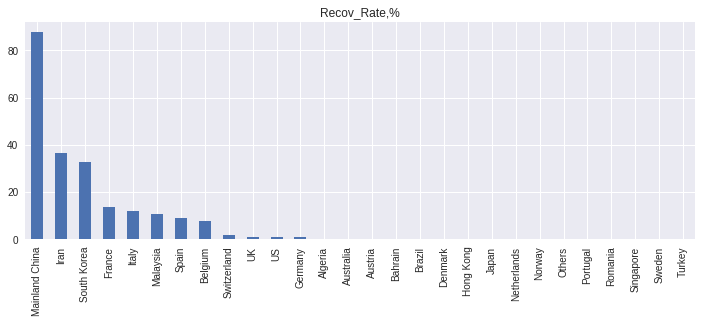

In [8]:
#Top_20_confirmed
#Interesting despite some countries repeated often in table (like US,Australia,Canada)
# they are not in high-rate confirmed disease
#Reason could be a low rate of desease spread in this region
max_confirm_by_c=pd.DataFrame(data_main.groupby(['Country/Region'])['Confirmed'].max()).sort_values(by=['Confirmed'],ascending=False)[:20]
max_depths_by_c=pd.DataFrame(data_main.groupby(['Country/Region'])['Deaths'].max()).sort_values(by=['Deaths'],ascending=False)[:20]
max_recov_by_c=pd.DataFrame(data_main.groupby(['Country/Region'])['Recovered'].max()).sort_values(by=['Recovered'],ascending=False)[:20]

# Death_Rate
death_r=pd.concat([max_confirm_by_c,max_depths_by_c],axis=1)
death_r['Death_Rate']=((death_r['Deaths']/death_r['Confirmed'])*100)
death_r=death_r.sort_values(by=['Death_Rate'],ascending=False)

# Recov_Rate
recov_r=pd.concat([max_confirm_by_c,max_recov_by_c],axis=1)
recov_r['Recov_Rate']=((recov_r['Recovered']/recov_r['Confirmed'])*100)
recov_r=recov_r.sort_values(by=['Recov_Rate'],ascending=False)

# Plot the figure.

fig,ax=plt.subplots(1,2,figsize=(12,4))
#plt.figure(figsize=(12, 8))
max_confirm_by_c.plot(kind='bar',ax=ax[0])
max_depths_by_c.plot(kind='bar',ax=ax[1],cmap='gray')    
ax[0].set_title('Amount Confirmed')
ax[1].set_title('Amount Deaths')
#ax.set_xlabel('Country')

fig1,ax=plt.subplots(1,1,figsize=(12,4))
death_r['Death_Rate'].plot(color='tab:blue',kind='bar',alpha=1).set_title('Death_Rate,%')

fig2,ax=plt.subplots(1,1,figsize=(12,4))
recov_r['Recov_Rate'].plot(kind='bar').set_title('Recov_Rate,%')

Observation:
1. Italy highest Death_Rate - around 8,5% (Even more than in China)
2. Top 3 (Death_Rate)- Italy,Iran,Spain - 8.5,8,6 %
3. China - 5 %

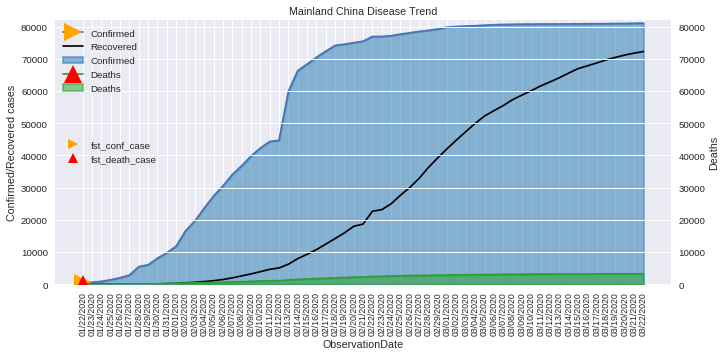

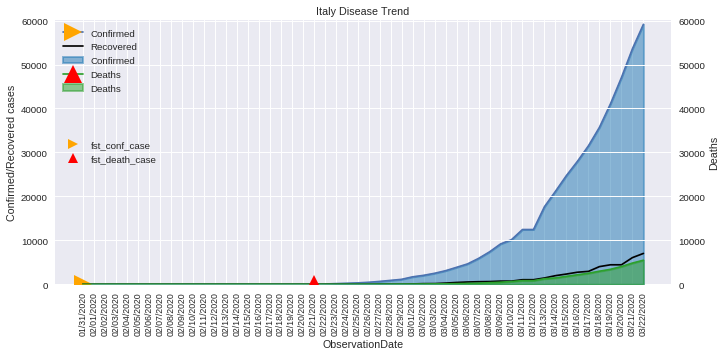

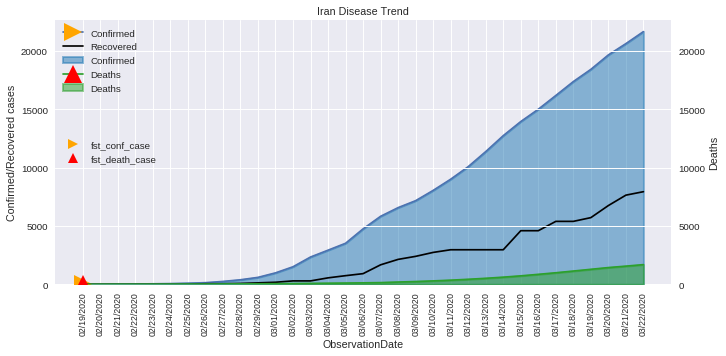

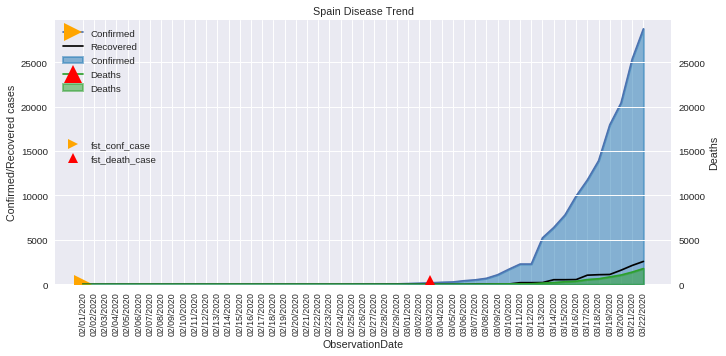

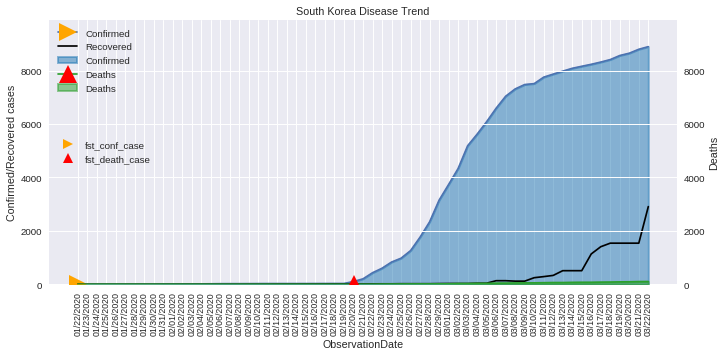

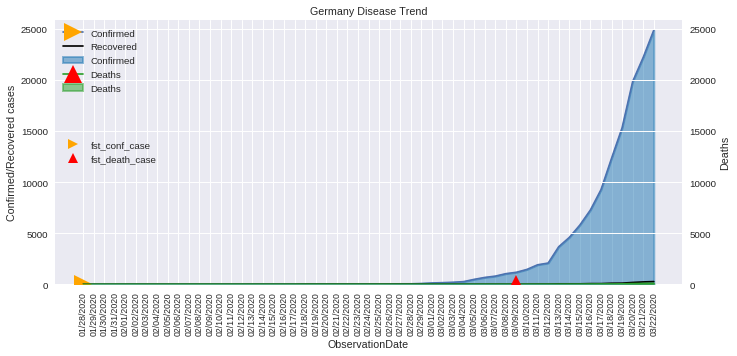

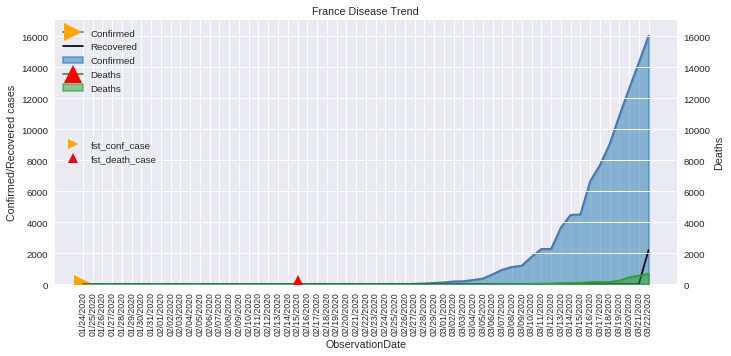

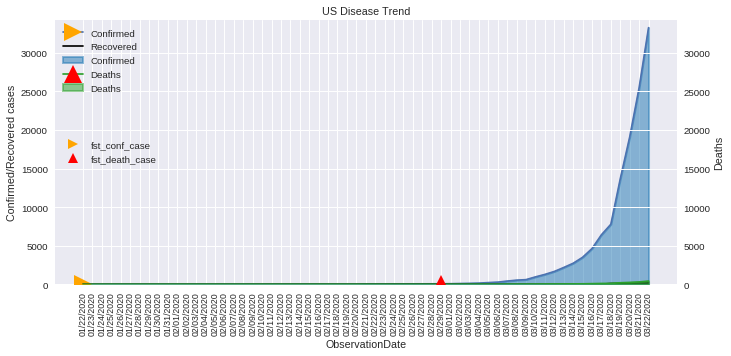

In [9]:
# Top_Countries_Main_Trends (Confirmed, Deaths,Recovery)

for i in ['Mainland China','Italy','Iran','Spain','South Korea','Germany','France','US']:
    df_count=data_main.loc[(data_main['Country/Region']==i)]
    # group by date (sum by Province)
    countr_conf_gr=pd.DataFrame(df_count.groupby(['ObservationDate'])['Confirmed'].sum()).reset_index()
    countr_death_gr=pd.DataFrame(df_count.groupby(['ObservationDate'])['Deaths'].sum()).reset_index()
    countr_recov_gr=pd.DataFrame(df_count.groupby(['ObservationDate'])['Recovered'].sum()).reset_index()
    
    countr_values=countr_conf_gr.merge(countr_death_gr,left_on='ObservationDate', right_on='ObservationDate')
    countr_values=countr_recov_gr.merge(countr_values,left_on='ObservationDate', right_on='ObservationDate')
    
    
    # First_Confirmed_Case
    fst_case_conf=countr_values.loc[countr_values['Confirmed']>0][:1].index[:1]
    fst_case_death=countr_values.loc[countr_values['Deaths']>0][:1].index[:1]
#Chart

    df1=countr_values
    df2=countr_values
    df3=countr_values
    col1='Confirmed'
    col2='Deaths'
    col3='Recovered'
    
    mycolors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:grey', 'tab:pink', 'tab:olive']      

    #figure,subplot
    fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi= 70)
    ax.set_title(str(i)+' '+'Disease Trend', fontsize=11)


    #Confirmed
    ax.fill_between(df1['ObservationDate'], y1=df1[col1],
                        label='Confirmed', alpha=0.5, color=mycolors[1],
                        y2=0, linewidth=2,zorder=1)
    plt.xticks(df1['ObservationDate'], fontsize=9, rotation=90)
    
    markers_on = fst_case_conf
    plt.plot(df1['ObservationDate'],df1['Confirmed'],markevery=markers_on,marker=('>'),markersize=18,
            markerfacecolor='orange',zorder=5,label='Confirmed')

    #plt.axvline('03/04/2020',color=mycolors[1],linewidth=1,linestyle="--")  #vertical line

    #Deaths
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.fill_between(df2['ObservationDate'], y1=df2[col2],
                        label='Deaths', alpha=0.5, color=mycolors[2],
                        y2=0, linewidth=2,zorder=1)
    markers_on1 = fst_case_death
    plt.plot(df2['ObservationDate'],df2['Deaths'],markevery=markers_on1,marker=('^'),markersize=18,
            markerfacecolor='red',color=mycolors[2])

    #Recovered

    ax.plot(df3['ObservationDate'],df3[col3],c='black',label='Recovered',
                alpha=2,zorder=5)

    # ask matplotlib for the plotted objects and their labels

    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    b=ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    
    

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    #ax.grid()
    #Axes_name
    ax.set_xlabel("ObservationDate")
    ax.set_ylabel(r"Confirmed/Recovered cases")
    ax2.set_ylabel(r"Deaths")

    ax.set_ylim(0,df1[col1].max()+1000)
    #ax2.set_ylim(0,df2[col2].max()+1000)
    ax2.set_ylim(0,df1[col1].max()+1000)
    
    #Marker
    
      
    fst_conf_case = mlines.Line2D([], [], color='orange', marker='>', linestyle='None',
                          markersize=10, label='fst_conf_case')
    fst_death_case  = mlines.Line2D([], [], color='red', marker='^', linestyle='None',
                          markersize=10, label='fst_death_case')

    
    ax = plt.gca().add_artist(b)
    plt.legend(handles=[fst_conf_case, fst_death_case],loc='center left')
 
    plt.show()

Observation:
1. Mainland China 40 days from 0 to stable 80 000
2. Mainland China Number of deaths still slightly increase
3. Now disease grow in China has Sigmoid form
3. Disease has an exponential grow in most countries

4. China-Amount of Recovered is approaching to Confirmed cases number for now
5. Italy 21 days between 1st Confirmed case and 1st Death
6. Spain 31 days between 1st Confirmed case and 1st Death
7. Germany 40 days between 1st Confirmed case and 1st Death
8. France 20 days between 1st Confirmed case and 1st Death

9. Europe counties for now - low rate of REcovered people - less than 10%
    -> long treatment required for disease elimination
10. Death rate in Europe less 8.5% (Italy), Spain (6%), France (4%), Germany(less 1%)

11. As a prediction we can consider - after 40 days of confirmed disease the amount of confirmed cases in country will be stabilized.


# China Active Confirmed-Amount of New Infected 

In [10]:

#imputer = SimpleImputer(strategy='constant')

#data_main= pd.DataFrame(imputer.fit_transform(data_main), columns=data_main.columns)
data_main['Active_conf']=data_main['Confirmed']-(data_main['Deaths']+data_main['Recovered'])
#data_main['Active_conf']=data_main['Active_conf'].astype(int)
#data_main['ObservationDate']=pd.to_datetime(data_main['ObservationDate'])

country=data_main.loc[data_main['Country/Region']=='Mainland China']
country_gr=pd.DataFrame(country.groupby(['ObservationDate'])['Active_conf'].sum()).reset_index()

In [11]:
country_gr[:3]

,ObservationDate,Active_conf
0,01/22/2020,502.0
1,01/23/2020,591.0
2,01/24/2020,854.0


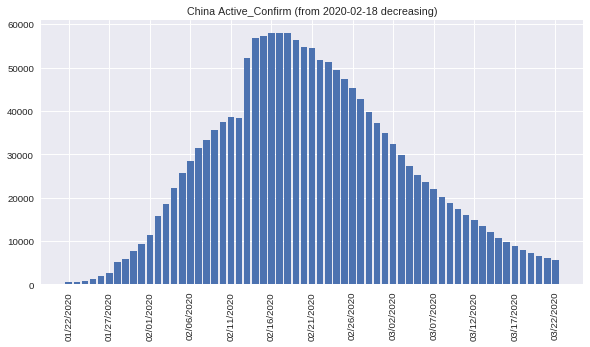

In [12]:

#country=data_main.loc[data_main['Country/Region']=='Mainland China']

fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi= 70)
ax.set_title('China Active_Confirm (from 2020-02-18 decreasing)', fontsize=11)

plt.bar(country_gr["ObservationDate"],country_gr["Active_conf"])
plt.xticks(country["ObservationDate"], fontsize=10, rotation=90)
ax.xaxis.set_major_locator(MaxNLocator(nbins=16))
#plt.axvline('2020-02-18',color=mycolors[1],linewidth=1,linestyle="--")  #vertical line
plt.show()

In [13]:
#Date with max Active_Confirmed
max_act_conf=country.loc[country['Active_conf']==country['Active_conf'].max()][:1].index[:1]
b=country['ObservationDate'][max_act_conf]
b

1715    02/18/2020
Name: ObservationDate, dtype: object

Observation:
1. China- 1 month from Epidemia start to reaching max Confirmed cases and Epidemia decreasing

# Prediction_China

In [14]:
#Active_confirmed_list
value=country_gr['Active_conf']
value[-5:]

56    8016.0
57    7256.0
58    6570.0
59    6010.0
60    5547.0
Name: Active_conf, dtype: float64

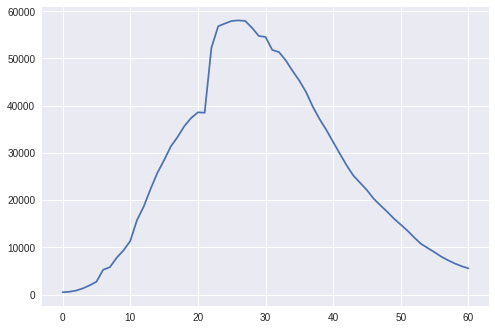

In [15]:
plt.plot(country_gr['Active_conf'].values)
#plt.xticks(country_gr["ObservationDate"], fontsize=10, rotation=90)
#ax.xaxis.set_major_locator(MaxNLocator(nbins=16))


In [16]:
#Define number of past trend that will be used for future prediction
past=15
future=10

start=past
end=len(value)-future

pr=[]
for i in range(start,end+1):
    row_past_future=value[(i-past):(i+future)]
    pr.append(list(row_past_future))

In [17]:
#Name for columns
past_columns=[f'past_{i}' for i in range(past)]
future_columns=[f'future_{i}' for i in range(future)]

In [18]:
#New df with past trend and future
df=pd.DataFrame(pr,columns=(past_columns+future_columns))

In [19]:
# Train/Test df
X=df[past_columns][:-1]
y=df[future_columns][:-1]

#Validation df
X_val=df[past_columns][-1:]
y_val=df[future_columns][-1:]

## Model fit and Error

In [20]:
from sklearn.linear_model import LinearRegression
LinReg=LinearRegression(normalize=True, fit_intercept=False)

In [21]:
LinReg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=True)

In [22]:

prediction=LinReg.predict(X_val)

In [23]:
prediction

array([[13479.92670794, 12652.8142154 , 11737.44409543, 11020.20775377,
        10735.46874756, 10513.97031457, 10420.65789968, 10445.56308209,
         9967.65314484,  9493.90893413]])

In [24]:
np.sqrt(mean_squared_error(y_val,prediction))


2616.252518720469

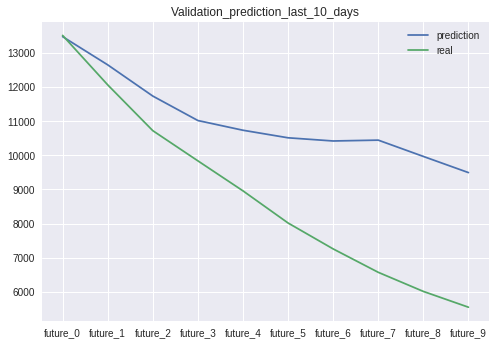

In [25]:
plt.plot(prediction[0], label='prediction')
plt.plot(y_val.iloc[0], label='real')
plt.title('Validation_prediction_last_10_days')
plt.legend()

# Prediction future days


In [26]:
future_forcast = np.array([i for i in range(len(country_gr['ObservationDate'])+future)]).reshape(-1, 1)

In [27]:
import datetime
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [28]:
#Last Columns for prediction
last_col=df.columns[-past:]
test=df[last_col][-1:]
#Prediction
X_train_=df[past_columns]
y_train_=df[future_columns]
X_test_=test

LinReg.fit(X_train_,y_train_)
prediction=LinReg.predict(X_test_)
prediction

array([[4922.06745716, 4463.19892176, 3996.36305968, 3692.38323156,
        3518.91901701, 3423.92158299, 3458.3581568 , 3557.72659343,
        3435.47125051, 3302.16837032]])

In [29]:
#Last known data to compare with prediction
y_train_[-1:]

,future_0,future_1,future_2,future_3,future_4,future_5,future_6,future_7,future_8,future_9
36,13516.0,12066.0,10723.0,9838.0,8958.0,8016.0,7256.0,6570.0,6010.0,5547.0


# Trend with Predicted

In [30]:
last_data=country_gr['Active_conf']
pred_data=prediction[0]
last_pred=list(last_data)+list(pred_data)


In [31]:
#dates
s=pd.DataFrame(future_forcast_dates)

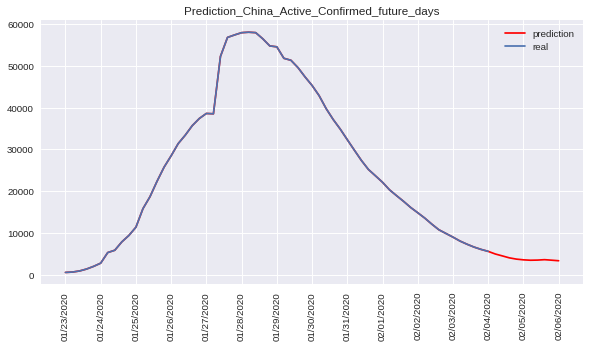

In [32]:

#chart
fig, ax = plt.subplots(1, 1, figsize=(10,5), dpi= 70)
plt.plot(last_pred, label='prediction',color='red')
plt.plot(country_gr['Active_conf'], label='real')
plt.title('Prediction_China_Active_Confirmed_future_days')
plt.xticks(range(0,len(s.index)), s[0],fontsize=10, rotation=90)

ax.xaxis.set_major_locator(MaxNLocator(nbins=16))
plt.legend()

# Conclusion:

1. We get visualization base on Confirmed,Deaths and Recovered trends
2. Prediction for China Active Confirmed Trend was done

# Further steps:
1. Try more models and tune them
2. Forecast for more countries****

#### Predictions China

array([[4922.06745716, 4463.19892176, 3996.36305968, 3692.38323156,
        3518.91901701, 3423.92158299, 3458.3581568 , 3557.72659343,
        3435.47125051, 3302.16837032]])

from 23.03.2020